In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

In [2]:
def psi(g,e):
    return np.array([g, e])

#def pulse(t, Omega0, delPrime):
#    Omega = np.sqrt(Omega0**2 + delPrime**2)
#    
#    return np.array([[np.cos(Omega*t/2.0) -(1.0j*delPrime/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
#             [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delPrime/Omega)*np.sin(Omega*t/2.0)]])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def phi(psi):
    phi0 = math.atan2(np.real(psi[0]),np.imag(psi[0]))
    phi1 = math.atan2(np.real(psi[1]),np.imag(psi[1]))
    return (phi0-phi1)

def blochVec(psi):
    w = rhogg(psi) - rhoee(psi)  #pointed up is ground state
    if abs(w)>1.0:
        w = float(round(w))
    x = np.sin(np.arccos(w))*np.cos(phi(psi))
    y = np.sin(np.arccos(w))*np.sin(phi(psi))
    return np.array([x,y,w])

def hyperRamseyP(psi0, t1, T, t2, delta, delPrime, Omega0):
    #psi0 = original state
    #t1 = pulse 1 duration
    #T = dark time
    #t2 = pulse 2 duration
    #Omega0 = rabi freq
    #delta = dark time detuning
    #delPrime = pulse detuning
    #phi = phase injection
    
    #pulse(t, Omega0, delta, phi0, phi1):
    pulse1 = pulse(t1, Omega0, delPrime, 0.0, 0.0)
    pulse2 = pulse(t2, Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0) 
    
    return pulse2@freeEvo@pi2PhaseInj@pulse1@psi0

def hyperRamseyM(psi0, t1, T, t2, delta, delPrime, Omega0):
    #psi0 = original state
    #t1 = pulse 1 duration
    #T = dark time
    #t2 = pulse 2 duration
    #Omega0 = rabi freq
    #delta = dark time detuning
    #delPrime = pulse detuning
    #phi = phase injection
    
    #pulse(t, Omega0, delta, phi0, phi1):
    pulse1 = pulse(t1, Omega0, delPrime, 0.0, 0.0)
    pulse2 = pulse(t2, Omega0, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInj = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0) 
    
    return pulse2@freeEvo@pi2PhaseInj@pulse1@psi0

def HRerrSig(psi0, t1, T, t2, delta, delPrime, Omega0):
    RhoeeP = rhoee(hyperRamseyP(psi0,t1,T,t2,delta,delPrime,Omega0))
    RhoeeM = rhoee(hyperRamseyM(psi0,t1,T,t2,delta,delPrime,Omega0))
    return RhoeeP - RhoeeM

In [3]:
def HRvalidate_interval(psi0, t1, T, t2, Delta, Omega0, x0, x1):
    return HRerrSig(psi0, t1, T, t2, x0, x0+Delta, Omega0) * HRerrSig(psi0, t1, T, t2, x1, x1+Delta, Omega0) < 0

def error_bound(a, b, err):
    n = np.log((b - a) / err) / np.log(2)
    return int(np.ceil(n))

def HRfindRoot(psi0, t1, T, t2, Delta, Omega0, tol):
    x0 = -0.1*Delta/(Omega0*T) - 0.05*np.abs(2.0*Delta/(Omega0*T)) - 0.01
    x1 = -0.1*Delta/(Omega0*T) + 0.05*np.abs(2.0*Delta/(Omega0*T)) + 0.01
    #print(x0,x1)
    
    if not HRvalidate_interval(psi0, t1, T, t2, Delta, Omega0, x0, x1):
        print("not valid interval")
        return
    
    n = error_bound(x0, x1, tol)
    counter = 1
    
    while True:
        root_approx = x0 + ((x1 - x0) / 2.0) 
        y = HRerrSig(psi0, t1, T, t2, root_approx, root_approx+Delta, Omega0)
        if -tol < y < tol:
            return root_approx
        if HRvalidate_interval(psi0, t1, T, t2, Delta, Omega0, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx
        counter +=1

In [4]:
def validate_interval(psi0, t, Delta, Omega0, x0, x1):
    return errSig(psi0, t, x0, x0+Delta, Omega0) * errSig(psi0, t, x1, x1+Delta, Omega0) < 0

def error_bound(a, b, err):
    n = np.log((b - a) / err) / np.log(2)
    return int(np.ceil(n))

def findRoot(psi0, t, Delta, Omega0, tol):  
    x0 = -2.0*Delta/(Omega0*t) - 0.5*np.abs(2.0*Delta/(Omega0*t)) - 0.01
    x1 = -2.0*Delta/(Omega0*t) + 0.5*np.abs(2.0*Delta/(Omega0*t)) + 0.01
    
    if not validate_interval(psi0, t, Delta, Omega0, x0, x1):
        print("not valid interval")
        return
    
    n = error_bound(x0, x1, tol)
    counter = 1
    
    while True:
        root_approx = x0 + ((x1 - x0) / 2.0) 
        y = errSig(psi0, t, root_approx, root_approx+Delta, Omega0)
        if -tol < y < tol:
            return root_approx
        if validate_interval(psi0, t, Delta, Omega0, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx
        counter +=1

-0.11 0.01


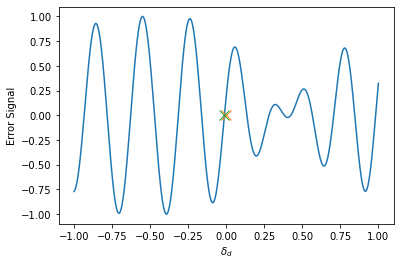

In [60]:
psi0 = psi(0.0, 1.0)
Delta = 0.5
Omega0 = 1.0
t1 = np.pi/(2.0*Omega0)
T = 20.0/Omega0
t2 = 3.0*np.pi/(2.0*Omega0)
tol = 1.0e-10

pts = 1000
delds = np.linspace(-1.0, 1.0, pts)
errSigPts = [0.0]*pts
RhoeeP = [0.0]*pts
RhoeeM = [0.0]*pts
dif = [0.0]*pts

for ii in range(pts):
    #def errSig(psi0, t, dark detuning, pulse detuning, Omega0):
    RhoeeP[ii] = rhoee(hyperRamseyP(psi0, t1, T, t2, delds[ii], delds[ii]+Delta, 1.0))
    RhoeeM[ii] = rhoee(hyperRamseyM(psi0, t1, T, t2, delds[ii], delds[ii]+Delta, 1.0))
    errSigPts[ii] = HRerrSig(psi0, t1, T, t2, delds[ii], Delta+delds[ii], Omega0)
    dif[ii] = RhoeeP[ii] - RhoeeM[ii]

plt.plot(delds, errSigPts)
#plt.plot(delds, RhoeeP, label = "$+\pi/2$")
#plt.plot(delds, RhoeeM, label = "$-\pi/2$")
plt.xlabel('$\delta_d$')
plt.ylabel('Error Signal')
plt.plot([0.0], [0.0], marker="x", markersize=10)
plt.plot([HRfindRoot(psi0, t1, T, t2, Delta, Omega0, tol)], [0.0], marker="x", markersize=10)
#plt.legend()
plt.show()

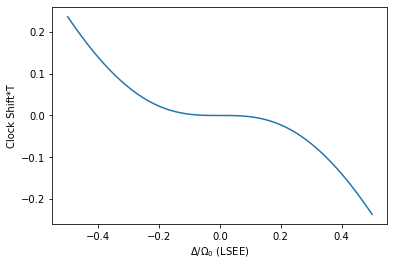

In [5]:
psi0 = psi(0.0, 1.0)
Omega0 = 1.0
t1 = np.pi/(2.0*Omega0)
T = 20.0/Omega0
t2 = 3.0*np.pi/(2.0*Omega0)
tol = 1.0e-10

pts = 101
Deltas = np.linspace(-0.5, 0.5, pts)
clockShifts = [0.0]*pts

for ii in range(pts):
    clockShifts[ii] = T*HRfindRoot(psi0, t1, T, t2, Deltas[ii], Omega0, tol)
    
plt.plot(Deltas, clockShifts)
plt.xlabel("$\Delta / \Omega_0$ (LSEE)")
plt.ylabel('Clock Shift*T')
plt.show()

In [6]:
clockShifts

[0.2369269551243633,
 0.22621480197925117,
 0.21571745045483118,
 0.20543848700262607,
 0.19538154215179382,
 0.18555028101894996,
 0.1759483928494155,
 0.16657957916986205,
 0.15744753969646996,
 0.1485559576414526,
 0.1399084833264351,
 0.13150871593877675,
 0.12336018283106387,
 0.11546631755214185,
 0.1078304366618395,
 0.10045571198919788,
 0.09334514404460786,
 0.08650153017137202,
 0.07992743269354104,
 0.07362514375150205,
 0.06759664823766799,
 0.061843585133552585,
 0.056367205843329424,
 0.05116833229362962,
 0.04624731168802827,
 0.0416039720410481,
 0.03723757538199427,
 0.03314677082281559,
 0.029329548472538557,
 0.025783192883245664,
 0.022504239473491894,
 0.019488431541249185,
 0.016730680538341397,
 0.014225030968897046,
 0.011964629612863067,
 0.009941699383780343,
 0.008147521303966659,
 0.0065724229868501325,
 0.005205775622278449,
 0.004036000396125021,
 0.0030505846440791835,
 0.002236107627861216,
 0.0015782777518033846,
 0.0010619810279459024,
 0.0006713380962